# Instruments, data and methods

This section describes the two types of drifters deployed during OTC25, as well as the data and trajectory reconstruction methods used in our analysis.
We first present the design of the MELODI and SPOT drifters.
Next, we introduce the different satellite-derived and drifter datasets (including the preprocessing steps applied when relevant).
Finally, we detail the Lagrangian statistics used to characterize the drift dynamics, the trajectory reconstruction methods implemented, and the metrics employed to evaluate them.

## Drifters deployed during the campain

At the time of writing only eOdyn MELODI and IGE SPOT data are available. We therefore focus on these two types of drifters; however, it should be mentioned that 16 OpenMetBuoy, 4 CLS MARGE-T II, and 1 Sofar Spotter buoys were also deployed during the campaign.
Including these additional drifters would help strengthen our analysis, as described in @sec-disc.

::: {#fig-deployment-dream-team layout-ncol=2}

![](images/IMG_0855.jpeg){width=45%}

![](images/IMG_7459.jpeg){width=45%}

Drifters deployment dream team.
:::

Drifter deployments were conducted by a very enthusiastic team of students and professors, mostly visible in @fig-deployment-dream-team.
A huge thanks to all of you!!!

### MELODI

The MELODI [@MELODI] is a surface drifter developed by the company eOdyn.
Although we are only interested in the drifter's position, it also measures surface currents, surface temperature and wave parameters.
The position is determined using several satellite constellations, with a sampling frequency of 1 hour.
The drifter uses the Iridium satellite network to transmit its data.
It is powered by four Li-ion 3500 mAh, 3.7 V batteries and a 6 W solar panel, which allows it to operate for at least several months.
Thanks to its low-profile, see @fig-melodi-design, the MELODI drifter is expected to be only weakly affected by wind drift.

![Design of the MELODI drifter](images/melodi-design.png){#fig-melodi-design width=50%}

From Tromsø to Nice, 18 MELODI drifters were deployed in various locations: in the North Sea and its Lofoten eddy, in the North Atlantic (including during a storm event), before and after the Strait of Gibraltar (within the Alboran eddy), and in the western Mediterranean Sea.
This can be seen in @fig-drifter-deployments.

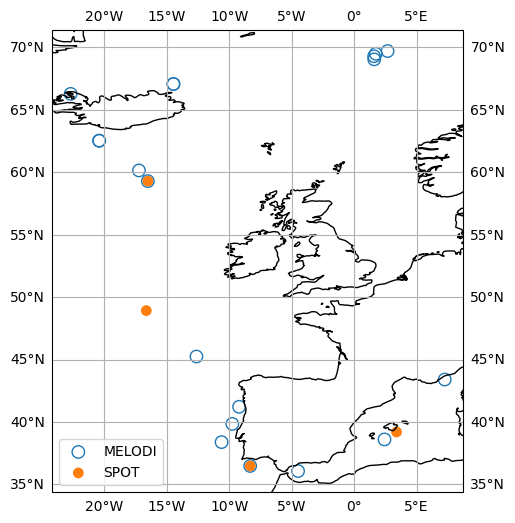

In [26]:
#| label: fig-drifter-deployments
#| fig-cap: "MELODI and SPOT drifter deployments during the OTC25 campaign."

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd


deployments = pd.read_csv("../data/drifters/deploy_time.csv", parse_dates=["deploy_time"], delimiter=" ")
deployments = deployments[deployments["type"].isin(["MELODI", "SPOT"])]
deployments = deployments.drop_duplicates(subset=["deploy_time", "lat", "lon"], keep="first")
deployments["lat"] = deployments["lat"].astype(float)
deployments["lon"] = deployments["lon"].astype(float)

style_map = {
    "MELODI": {"facecolors": "none", "edgecolors": "tab:blue", "marker": "o", "s": 80, "label": "MELODI"},
    "SPOT": {"facecolors": "tab:orange", "edgecolors": "none", "marker": "o", "s": 60, "label": "SPOT"},
}

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for t, style in style_map.items():
    subset = deployments[deployments["type"] == t]
    ax.scatter(
        subset["lon"], subset["lat"],
        transform=ccrs.PlateCarree(),
        **style
    )

ax.legend(loc="lower left")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

### SPOT

The SPOT [@SPOT] is a home-made surface drifter designed and developed at Institut des Géosciences de l'Environnement (IGE).
Its design is very simple, see @fig-spot-design: a weighted waterproof jar containing a GPS tracer powered by external batteries.
The GPS tracer is a SPOT Trace, which uses the Globalstar satellite network to transmit its position every 30 minutes.
External batteries (4 LR20 alkaline 1.5V 13Ah) allow the drifter to operate for up to 6 months and counting at the time of writing.

![Design of the SPOT drifter](images/spot-design.png){#fig-spot-design width=75%}

During the first deployments we noticed that the SPOT drifters exhibited an orbital motion around their vertical axis and we suspected that it was the cause for the observed effective sampling frequency being larger than the nominal 30 minutes (see @fig-spot-sampling-frequency).
To mitigate this motion we designed a dynamic anchor attached to the bottom of the drifter.
Being at sea we had to reuse material available aboard the ship: old sails and steel wire ropes, as visible in @fig-spot-anchor.

![SPOT drifter with a dynamic anchor](images/IMG_0538.jpeg){#fig-spot-anchor width=75%}

The last 5 drifters deployed in the Mediterranean Sea were equipped with this anchor.
Using the drifter data presented in @sec-data-drif-traj it seems that the anchor was effective in improving the effective sampling frequency, as shown in @fig-spot-sampling-frequency.
Further analysis would be required to confirm this is due to the dynamic anchor and not because of an overall quieter sea state in the Mediterranean Sea.

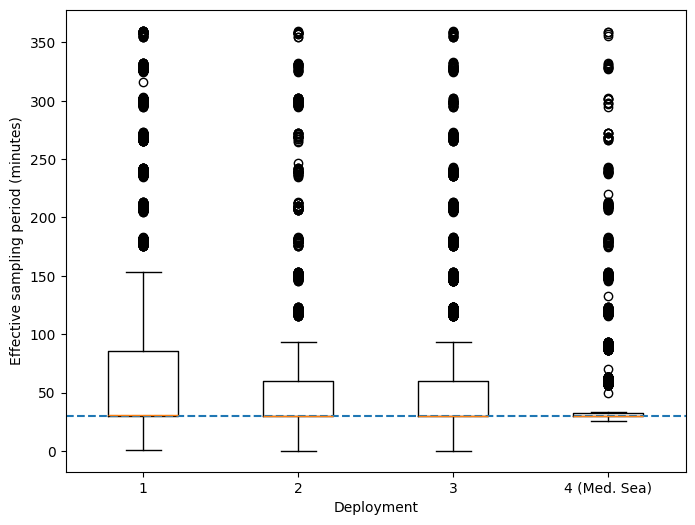

In [39]:
#| label: fig-spot-sampling-frequency
#| fig-cap: "SPOT drifters effective sampling period. The dashed blue line indicates the nominal sampling period of 30 minutes."

import os

import matplotlib.pyplot as plt
import pandas as pd


base_dir = "../data/drifters"
l1_dir = f"{base_dir}/l1"

df = pd.read_parquet(os.path.join(l1_dir, "spot_l1_df.parquet"))
deploy_times = df["deploy_time"].drop_duplicates().sort_values()

sampling_periods = []
for deploy_time in deploy_times:
    subset = df[df["deploy_time"] == deploy_time]
    sampling_periods.append(subset["dt"].dropna().to_numpy() / 60)

fig, ax = plt.subplots(figsize=(8, 6))

ax.boxplot(sampling_periods)
ax.axhline(30, color="tab:blue", linestyle="--")

ax.set_xticklabels(["1", "2", "3", "4 (Med. Sea)"])
ax.set_xlabel("Deployment")
ax.set_ylabel("Effective sampling period (minutes)")

plt.show()

## Satellite and drifter data

Our analysis requires both maps of geophysical quantities (surface currents, waves, winds) and lagrangian drifter trajectories. 

### Satellite-derived gridded products

Geophysical quantities of interest are derived from satellite observations, assimilated in physical models of varying complexity.

#### Sea Surface Height
VarDyn is a variational mapping method jointly reconstructing Sea Surface Height (SSH) and Sea Surface Temperature (SST) [@leguillouVarDynDynamicalJointReconstructions2025].
The version used in our analysis assimilates both SWOT KaRin and Nadir altimeters data and produces daily 0.05° $\times$ 0.05° maps.
This dataset provides both SSH and sea surface currents, derived from the SSH field using the cyclogeostrophic inversion method proposed by @bertrandRobustVariationalFramework2025 and implemented in the Python package `jaxparrow` [@bertrandJaxparrow2025].

#### Sea Surface Wind
Wind acts both directly on the drifter (the leeway) and indirectly through its effect on waves and currents.
We use the wind velocity at 10 meters above the surface from the 0.125° $\times$ 0.125° hourly ECMWF bias corrected product [@SeaSurfaceWind] developed by the Royal Netherlands Meteorological Institute.

#### Sea State
Waves also affect drifter trajectories through the Stokes drift.
We employ the Stokes drift obtained by assimilating significant wave height in the wave model MFWAM, available in the 0.083° $\times$ 0.083° hourly Global Ocean Waves Analysis and Forecast product [@SeaState] developed by Mercator Ocean International.

### Drifter trajectories {#sec-data-drif-traj}

Starting from the raw GPS positions transmitted by the drifters, we perform several preprocessing steps before using them in our analysis.

#### L0 version

The L0 version of the data consists of datasets containing the original timestamps and positions (latitude and longitude) for each drifter, complemented by its deployment date and time.
Each record also includes the time interval between successive measurements, the zonal and meridional distances between positions $i$ and $i+1$, and the corresponding zonal and meridional velocity components needed to move from position $i$ to position $i+1$.

In [ ]:
#| echo: false

import glob
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import raw_to_l0


def do_raw_to_l0(dataset):
    raw_files = glob.glob(os.path.join(raw_dir, dataset, "*.json"))
    l0_df, l0_ds = raw_to_l0(raw_files, deployment_dates)

    l0_df.to_parquet(os.path.join(l0_dir, f"{dataset}_l0_df.parquet"), index=False)
    l0_ds.to_zarr(os.path.join(l0_dir, f"{dataset}_l0_ds.zarr"), mode="w")


base_dir = "../data/drifters"
raw_dir = f"{base_dir}/raw"
l0_dir = f"{base_dir}/l0"

deployment_dates = pd.read_csv(os.path.join(base_dir, "deploy_time.csv"), delimiter=" ")
deployment_dates["deploy_time"] = pd.to_datetime(deployment_dates["deploy_time"], format="%Y-%m-%dT%H:%M:%SZ", utc=True)

do_raw_to_l0("spot")
do_raw_to_l0("melodi")

/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


#### L1 version

The L1 version of the data is obtained by applying the following Quality Control (QC) steps to the L0 data:

1. Original spurious GPS locations were removed following @elipotGlobalSurfaceDrifter2016,
2. Curated trajectories are divided into segments when the difference between two consecutive timestamps exceeds 6 hours.

In [ ]:
#| echo: false

import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from drifters_data import l0_to_l1


def do_l0_to_l1(dataset):
    l0_df = pd.read_parquet(os.path.join(l0_dir, f"{dataset}_l0_df.parquet"))
    l1_df, l1_ds = l0_to_l1(l0_df)

    l1_df.to_parquet(os.path.join(l1_dir, f"{dataset}_l1_df.parquet"), index=False)
    l1_ds.to_zarr(os.path.join(l1_dir, f"{dataset}_l1_ds.zarr"), mode="w")

    nobs_l0 = len(l0_df)
    ntraj_l0 = l0_df["drifter_id"].nunique()
    nobs_l1 = len(l1_df)
    ntraj_l1 = len(l1_ds["rows"])

    return nobs_l0, ntraj_l0, nobs_l1, ntraj_l1


base_dir = "../data/drifters"
l0_dir = f"{base_dir}/l0"
l1_dir = f"{base_dir}/l1"

nobs_spot_l0, ntraj_spot_l0, nobs_spot_l1, ntraj_spot_l1 = do_l0_to_l1("spot")
nobs_melodi_l0, ntraj_melodi_l0, nobs_melodi_l1, ntraj_melodi_l1 = do_l0_to_l1("melodi")

/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/Users/bertrava/miniconda3/envs/vb-phd/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


As can be seen in @tbl-qc-numbers, these QC steps result in only a small reduction of the number of observations, both for the SPOT and MELODI drifters.
However, the number of segments is significantly increased, especially for the SPOT drifters, which were more prone to transmission issues as previously mentionned.

In [9]:
#| label: tbl-qc-numbers
#| tbl-cap: Number of observations and segments in L0 and L1 versions for SPOT and MELODI datasets.

from IPython.display import display

import pandas as pd


column_names = pd.DataFrame(
    [
        ["# Observations", "L0"], 
        ["# Observations", "L1"], 
        ["# Segments", "L0"], 
        ["# Segments", "L1"]
    ],
    columns=["Dataset", ""]
)

rows = [
    [nobs_spot_l0, nobs_spot_l1, ntraj_spot_l0, ntraj_spot_l1],
    [nobs_melodi_l0, nobs_melodi_l1, ntraj_melodi_l0, ntraj_melodi_l1]
]

columns = pd.MultiIndex.from_frame(column_names)
index = ["SPOT", "MELODI"]

df = pd.DataFrame(rows, columns=columns, index=index)
display(df)

Dataset # Observations        # Segments     
                    L0     L1         L0   L1
SPOT             24503  23849         20  837
MELODI           47398  46890         19   49

#### L2 version

1. Remove trajectories smaller than 1 day?
2. Resample to regular timestamps (every hour or every 6 hours)?